In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!git clone https://github.com/razorx89/roco-dataset.git

Cloning into 'roco-dataset'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 114 (delta 7), reused 20 (delta 7), pack-reused 91 (from 1)
Receiving objects: 100% (114/114), 13.01 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (31/31), done.


CROSS CHECKING THE PATH


In [51]:
# Here we are reading the captions from a file ,removing the extra space whitespace and printing the first five captions

with open('/content/drive/MyDrive/ROCO/data/test/radiology/captions.txt', 'r') as f:
    captions = f.readlines()

captions = [caption.strip() for caption in captions]

for caption in captions[:5]:
    print(caption)


ROCO_00001	 Axial MRI (coronal view).
ROCO_00006	 Coronal plain computed tomography image showing multiple large tumor masses with edge enhancement inside the abdominal cavity and liver.
ROCO_00016	 Axial source image from an intracranial magnetic resonance angiogram reveals abnormal arterial signal elevation in the left more than right cavernous sinuses consistent with a carotid cavernous fistula, as indicated by the arrow.
ROCO_00025	 The apical height, homogeneity, and the thickness of mineral trioxide aggregate plug
ROCO_00031	 CTO of RCA (closure in the 2nd segment)


In [52]:
# Creation of DataFrame

import pandas as pd

df = pd.read_table('/content/drive/MyDrive/ROCO/data/test/radiology/captions.txt', delimiter='\t', header=None, encoding='utf-8')
print(df)

               0                                                  1
0     ROCO_00001                          Axial MRI (coronal view).
1     ROCO_00006   Coronal plain computed tomography image showi...
2     ROCO_00016   Axial source image from an intracranial magne...
3     ROCO_00025   The apical height, homogeneity, and the thick...
4     ROCO_00031            CTO of RCA (closure in the 2nd segment)
...          ...                                                ...
8174  ROCO_81771   Damus–Kaye–Stansel shunt. Oblique coronal MIP...
8175  ROCO_81778   MRI pelvis post-radiation, axial STIR/T2W FSE...
8176  ROCO_81792   Fluoroscopic image showing attempts to grab t...
8177  ROCO_81796   Positron emission tomography–computed tomogra...
8178  ROCO_81798   Cholangiography showing the metallic stent pl...

[8179 rows x 2 columns]


In [53]:

# Assigning column names
df.columns = ['Id', 'caption']

# Striped whitespaces from both columns
df['Id'] = df['Id'].str.strip()
df['caption'] = df['caption'].str.strip()

print("Revisied DataFrame:\n", df.head())


Revisied DataFrame:
            Id                                            caption
0  ROCO_00001                          Axial MRI (coronal view).
1  ROCO_00006  Coronal plain computed tomography image showin...
2  ROCO_00016  Axial source image from an intracranial magnet...
3  ROCO_00025  The apical height, homogeneity, and the thickn...
4  ROCO_00031            CTO of RCA (closure in the 2nd segment)



DATA FRAME ANALYSIS


In [63]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms as transforms

In [64]:

base_path= '/content/drive/MyDrive/ROCO/data'
data_splits = ['train', 'test', 'validation']
subfolders = ['radiology', 'non-radiology']
sample_size_per_category = 1000
data= []

In [65]:
# Filter out 'non-radiology' subfolder
for split in data_splits:
    for subfolder in subfolders:
        if subfolder == "non-radiology":
            continue  # Skip 'non-radiology' subfolder

        caption_file = os.path.join(base_path, split, subfolder, 'captions.txt')
        image_folder = os.path.join(base_path, split, subfolder, 'images')

        # Read a subset of captions
        with open(caption_file, 'r') as file:
            # Collect only the first `sample_size_per_category` captions
            for i, line in enumerate(file):
                if i >= sample_size_per_category:
                    break

                match = re.match(r"^(\S+)\s+(.*)$", line.strip())
                if match:
                    image_id = match.group(1)
                    caption = match.group(2)
                    image_path = os.path.join(image_folder, f"{image_id}.jpg")

                    # Append data entry to list
                    data.append({
                        'image_id': image_id,
                        'caption': caption,
                        'label': subfolder,
                        'split': split,
                        'image_path': image_path
                    })


In [67]:

sample_df = pd.DataFrame(data)
print("Sample DataFrame created with columns:", sample_df.columns)

Sample DataFrame created with columns: Index(['image_id', 'caption', 'label', 'split', 'image_path'], dtype='object')


In [68]:
print(sample_df.sample(n=5))

        image_id                                            caption  \
1035  ROCO_00428  T2-weighted MR sagittal image shows an isointe...   
975   ROCO_01218  Single intrauterine fetus of 10 weeks of gesta...   
22    ROCO_00029  Post-Treatment MRIAxial T1-weighted, contrast-...   
1420  ROCO_04397  X-ray chest showing improvement in effusion af...   
368   ROCO_00463          The picture shows severely injured liver.   

          label  split                                         image_path  
1035  radiology   test  /content/drive/MyDrive/ROCO/data/test/radiolog...  
975   radiology  train  /content/drive/MyDrive/ROCO/data/train/radiolo...  
22    radiology  train  /content/drive/MyDrive/ROCO/data/train/radiolo...  
1420  radiology   test  /content/drive/MyDrive/ROCO/data/test/radiolog...  
368   radiology  train  /content/drive/MyDrive/ROCO/data/train/radiolo...  


In [69]:
# Checking any missed values

missing_values = sample_df.isnull().sum()
print("Missing Values in each column:\n", missing_values)


Missing Values in each column:
 image_id      0
caption       0
label         0
split         0
image_path    0
dtype: int64


In [70]:
#checking for the Duplicates

duplicate_rows = sample_df[sample_df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [71]:
# Calculate the word count for each caption
sample_df['caption_word_count'] = sample_df['caption'].apply(lambda x: len(x.split()))

#Count of words on average
average_word_count = sample_df['caption_word_count'].mean()

print(f"Average word count of captions: {round(average_word_count, 2)}")


Average word count of captions: 19.99


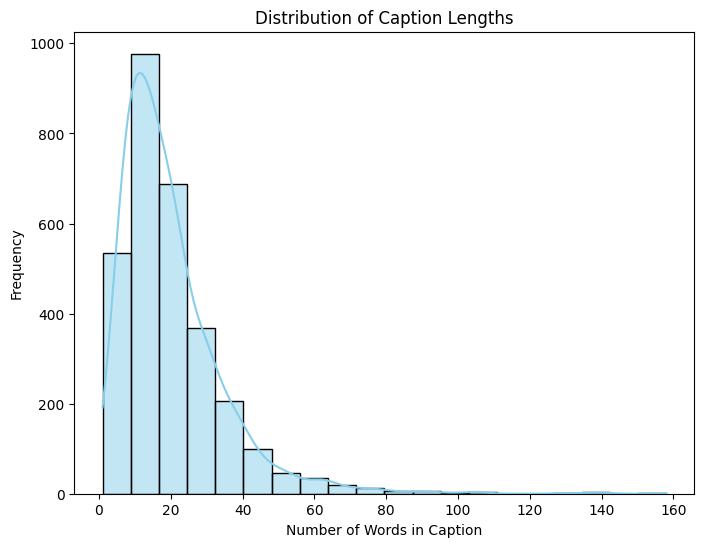

In [72]:
import seaborn as sns

# Plot a histogram of caption word counts
plt.figure(figsize=(8, 6))
sns.histplot(sample_df['caption_word_count'],kde =True ,bins=20, color='skyblue')
plt.title("Distribution of Caption Lengths")
plt.xlabel("Number of Words in Caption")
plt.ylabel("Frequency")
plt.show()


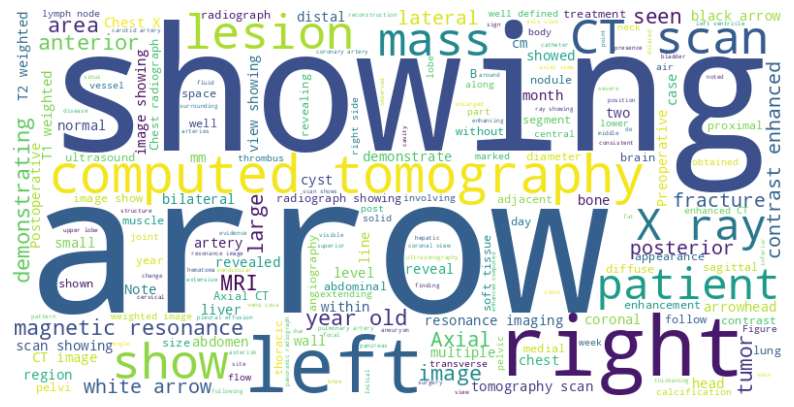

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all captions into a single string
text = " ".join(sample_df['caption'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


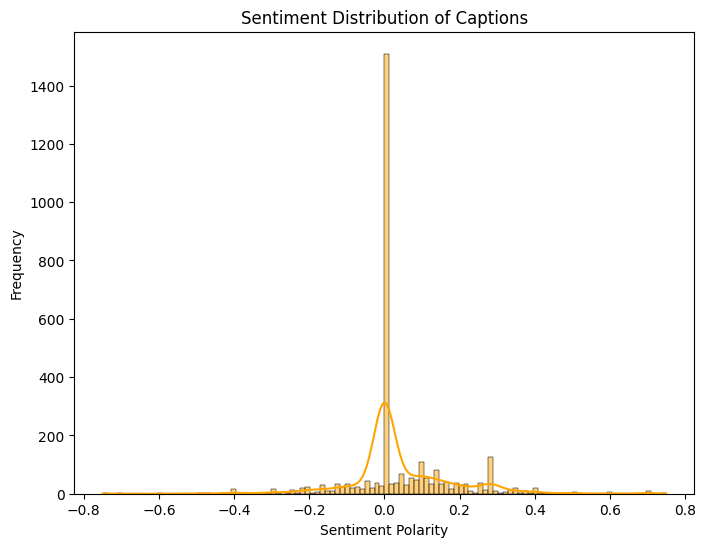

In [74]:
from textblob import TextBlob
# Polarity: This measures the sentiment of the text on a scale from -1 to 1.
# -1 means a negative sentiment.
#  0 means a neutral sentiment.
#  1 means a positive sentiment."""

# Perform sentiment analysis on each caption
sample_df['sentiment'] = sample_df['caption'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8, 6))
sns.histplot(sample_df['sentiment'], kde=True, color='orange')
plt.title("Sentiment Distribution of Captions")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


In [75]:

import pandas as pd
from PIL import Image
from IPython.display import Image as IPImage, display
import os

In [76]:

def load_image_for_display(image_path):
    # Return an IPImage that will be shown in Notebooks
    return IPImage(filename=image_path)

In [83]:

sample_df_limited =sample_df.sample(n=5)

In [84]:

image_paths = []
captions = []

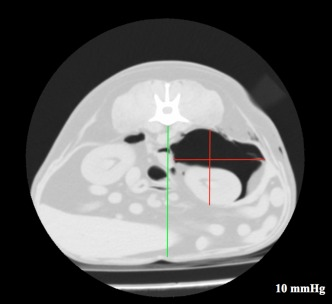

Caption: Transverse computed tomography image at the level of the 2nd lumbar vertebra for 10 mmHg CO2 insufflation pressure. The trocar was placed with the right approach. Maximum linear dimensions (maximum dorsoventral diameter and maximum transverse diameter [red lines]) were measured separately on left and right sides based on the mid‐sagittal plane as the medial border (green line).



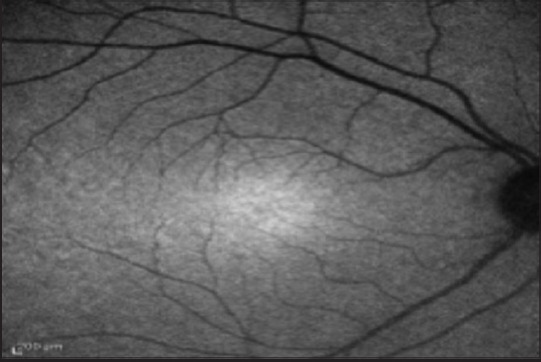

Caption: Near infra-red-autofluorescence image of a normal right eye



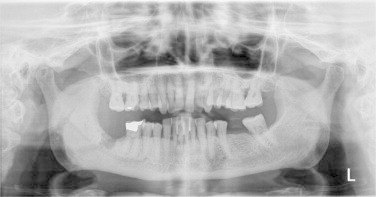

Caption: Panoramic radiograph taken 6.6.12.



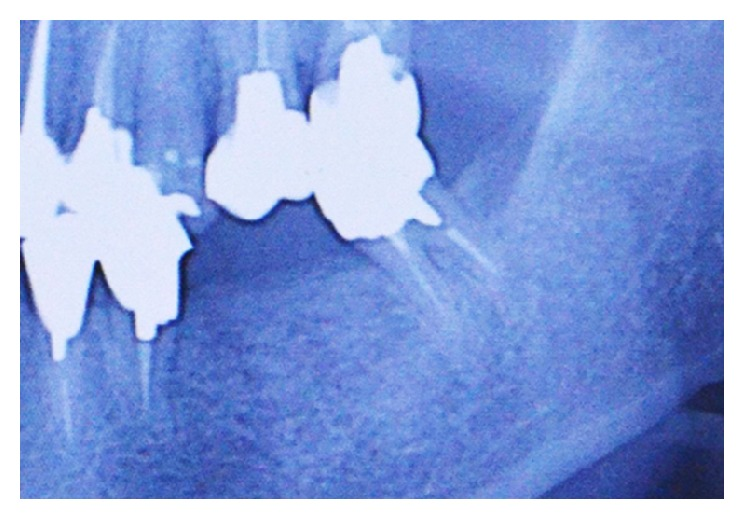

Caption: Panoramic radiographic image taken 2 months after exfoliation. No recurrence of bone formation was observed.



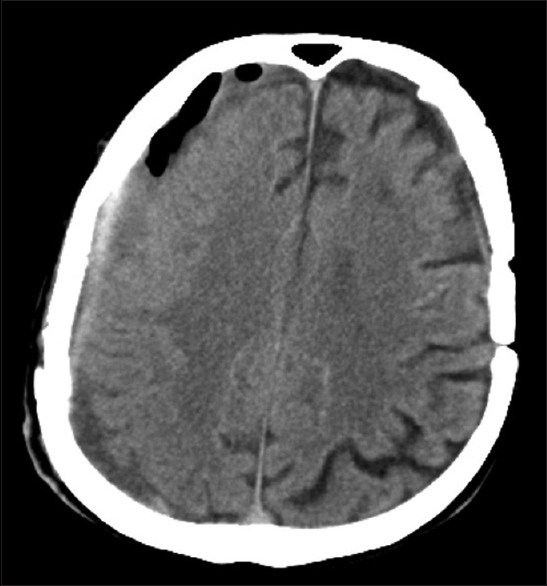

Caption: Simple pneumocephalus



In [85]:
for index, row in sample_df_limited.iterrows():
    image_id = row['image_id']
    caption = row['caption']
    split = row['split']
    label = row['label']

    image_path = os.path.join(base_path, split, label, 'images', f"{image_id}.jpg")

    # Display the image using IPython's Image function
    image_path = os.path.join( base_path, split, label, 'images', f"{image_id}.jpg")

    # Display the image using IPython's Image function
    display(IPImage(filename=image_path))

    # Display the caption for that image
    print(f"Caption: {caption}\n")

# Preprocessing Techniques

In [86]:
img_dir="/content/drive/MyDrive/ROCO/data/train/radiology/images"

In [87]:
import cv2
import numpy as np
import os

In [88]:
ima_files =[f for f in os.listdir(img_dir) if f.endswith(".jpg")]

In [89]:
ima_files

['ROCO_73483.jpg',
 'ROCO_73492.jpg',
 'ROCO_73496.jpg',
 'ROCO_73498.jpg',
 'ROCO_73505.jpg',
 'ROCO_73506.jpg',
 'ROCO_73521.jpg',
 'ROCO_73518.jpg',
 'ROCO_73534.jpg',
 'ROCO_73548.jpg',
 'ROCO_73555.jpg',
 'ROCO_73554.jpg',
 'ROCO_78382.jpg',
 'ROCO_73557.jpg',
 'ROCO_73568.jpg',
 'ROCO_73574.jpg',
 'ROCO_73589.jpg',
 'ROCO_73593.jpg',
 'ROCO_73594.jpg',
 'ROCO_73597.jpg',
 'ROCO_73611.jpg',
 'ROCO_73619.jpg',
 'ROCO_73627.jpg',
 'ROCO_73629.jpg',
 'ROCO_73631.jpg',
 'ROCO_74096.jpg',
 'ROCO_73681.jpg',
 'ROCO_73687.jpg',
 'ROCO_75955.jpg',
 'ROCO_73707.jpg',
 'ROCO_73717.jpg',
 'ROCO_73727.jpg',
 'ROCO_73744.jpg',
 'ROCO_73743.jpg',
 'ROCO_73757.jpg',
 'ROCO_73772.jpg',
 'ROCO_73775.jpg',
 'ROCO_73780.jpg',
 'ROCO_73807.jpg',
 'ROCO_73826.jpg',
 'ROCO_73834.jpg',
 'ROCO_73881.jpg',
 'ROCO_73889.jpg',
 'ROCO_73909.jpg',
 'ROCO_73912.jpg',
 'ROCO_73927.jpg',
 'ROCO_73934.jpg',
 'ROCO_79706.jpg',
 'ROCO_73945.jpg',
 'ROCO_73955.jpg',
 'ROCO_73956.jpg',
 'ROCO_73973.jpg',
 'ROCO_73975

In [90]:
img_path = os.path.join(img_dir,ima_files[4444])
img_path1 = os.path.join(img_dir,ima_files[144])


In [91]:
print(img_path)
print(img_path1)

/content/drive/MyDrive/ROCO/data/train/radiology/images/ROCO_51846.jpg
/content/drive/MyDrive/ROCO/data/train/radiology/images/ROCO_74751.jpg


In [92]:
img =cv2.imread(img_path)
img1 =cv2.imread(img_path1)

array([[[53, 31, 26],
        [54, 34, 23],
        [58, 36, 18],
        ...,
        [37, 26, 22],
        [39, 28, 24],
        [35, 26, 22]],

       [[55, 32, 24],
        [57, 36, 21],
        [62, 41, 19],
        ...,
        [31, 19, 15],
        [34, 23, 19],
        [33, 22, 18]],

       [[59, 36, 20],
        [63, 42, 20],
        [68, 48, 17],
        ...,
        [28, 16, 12],
        [32, 21, 17],
        [33, 22, 18]],

       ...,

       [[53, 33, 16],
        [58, 36, 18],
        [62, 38, 18],
        ...,
        [40, 22, 15],
        [41, 23, 16],
        [40, 24, 18]],

       [[53, 33, 16],
        [55, 35, 18],
        [59, 37, 19],
        ...,
        [40, 24, 18],
        [40, 24, 18],
        [40, 23, 20]],

       [[50, 32, 15],
        [55, 35, 18],
        [58, 36, 18],
        ...,
        [40, 24, 18],
        [40, 24, 18],
        [38, 21, 18]]], dtype=uint8)
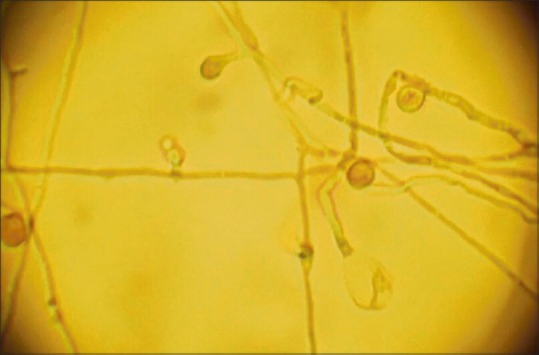

In [93]:
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
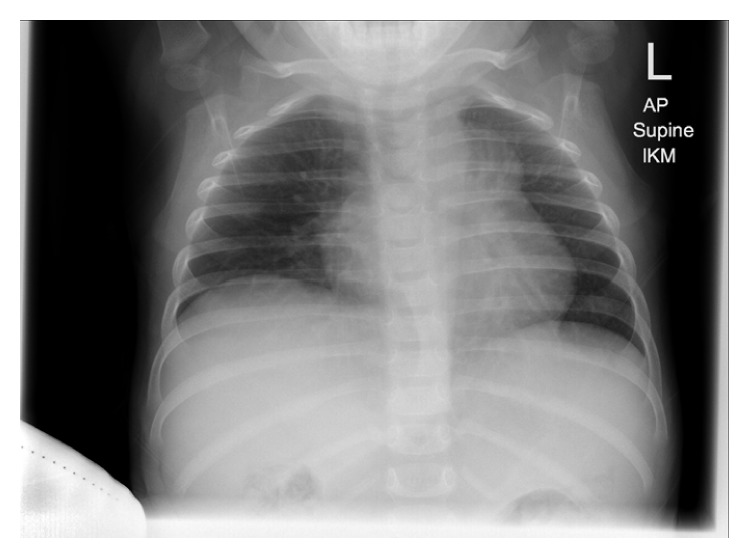

In [94]:
img1

array([[[54, 33, 23],
        [61, 42, 11],
        [69, 50, 10],
        ...,
        [42, 26, 19],
        [37, 24, 20],
        [37, 26, 22]],

       [[61, 40, 20],
        [71, 53, 12],
        [80, 60, 13],
        ...,
        [38, 20, 13],
        [33, 19, 13],
        [32, 21, 17]],

       [[66, 45, 15],
        [76, 57, 10],
        [78, 56,  4],
        ...,
        [42, 20, 12],
        [36, 18, 12],
        [36, 23, 19]],

       ...,

       [[55, 34, 16],
        [71, 43, 15],
        [78, 45, 10],
        ...,
        [56, 27,  5],
        [47, 23,  6],
        [42, 24, 15]],

       [[56, 35, 17],
        [63, 39, 17],
        [69, 39, 15],
        ...,
        [49, 25, 12],
        [42, 21, 13],
        [40, 23, 17]],

       [[54, 34, 17],
        [60, 36, 18],
        [63, 38, 17],
        ...,
        [48, 27, 16],
        [43, 25, 17],
        [39, 23, 18]]], dtype=uint8)
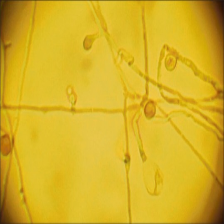

In [95]:
target_size=(224,224)
cv2.resize(img,target_size)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
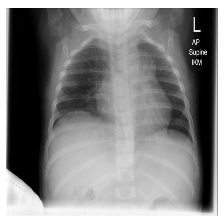

In [96]:
target_size1 =(224,224)
cv2.resize(img1,target_size)

In [97]:
img_processed = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [98]:
img_processed1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [99]:
img_normalised = img/255
img_normalised

array([[[0.20784314, 0.12156863, 0.10196078],
        [0.21176471, 0.13333333, 0.09019608],
        [0.22745098, 0.14117647, 0.07058824],
        ...,
        [0.14509804, 0.10196078, 0.08627451],
        [0.15294118, 0.10980392, 0.09411765],
        [0.1372549 , 0.10196078, 0.08627451]],

       [[0.21568627, 0.1254902 , 0.09411765],
        [0.22352941, 0.14117647, 0.08235294],
        [0.24313725, 0.16078431, 0.0745098 ],
        ...,
        [0.12156863, 0.0745098 , 0.05882353],
        [0.13333333, 0.09019608, 0.0745098 ],
        [0.12941176, 0.08627451, 0.07058824]],

       [[0.23137255, 0.14117647, 0.07843137],
        [0.24705882, 0.16470588, 0.07843137],
        [0.26666667, 0.18823529, 0.06666667],
        ...,
        [0.10980392, 0.0627451 , 0.04705882],
        [0.1254902 , 0.08235294, 0.06666667],
        [0.12941176, 0.08627451, 0.07058824]],

       ...,

       [[0.20784314, 0.12941176, 0.0627451 ],
        [0.22745098, 0.14117647, 0.07058824],
        [0.24313725, 0

In [100]:
# Applying histogram equalization and denoising

img_eq = cv2.equalizeHist(img_processed.squeeze())
print(f"Equalized Image (first 5 pixels): {img_eq[:5, :5]}")

img_denoised = cv2.GaussianBlur(img_eq, (5, 5), 0)
print(f"Denoised Image (first 5 pixels): {img_denoised[:5, :5]}")

Equalized Image (first 5 pixels): [[1 1 1 1 1]
 [1 1 1 1 2]
 [1 1 2 2 2]
 [1 1 2 2 2]
 [1 1 2 2 2]]
Denoised Image (first 5 pixels): [[1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 2 2]
 [1 1 2 2 2]
 [1 1 2 2 2]]


In [101]:
img_eq1 = cv2.equalizeHist(img_processed1.squeeze())
print(f"Equalized Image 1 (first 5 pixels): {img_eq1[:5, :5]}")

img_denoised1 = cv2.GaussianBlur(img_eq1, (5, 5), 0)
print(f"Denoised Image 1 (first 5 pixels): {img_denoised1[:5, :5]}")

Equalized Image 1 (first 5 pixels): [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]
Denoised Image 1 (first 5 pixels): [[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


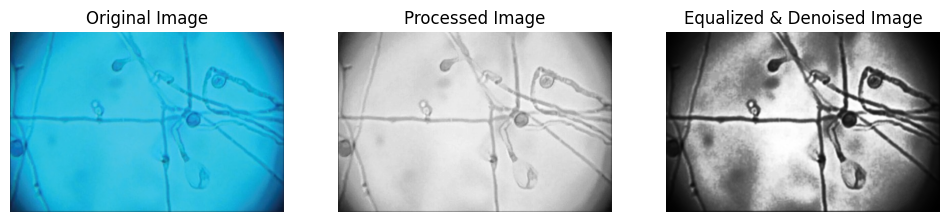

In [102]:
# Visualize the original, preprocessed, and denoised images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Processed Image (Grayscale & Normalized)
plt.subplot(1, 3, 2)
plt.imshow(img_processed.squeeze(), cmap='gray')
plt.title('Processed Image')
plt.axis('off')

# Equalized and Denoised Image (Optional)
plt.subplot(1, 3, 3)
plt.imshow(img_denoised, cmap='gray')
plt.title('Equalized & Denoised Image')
plt.axis('off')

plt.show()

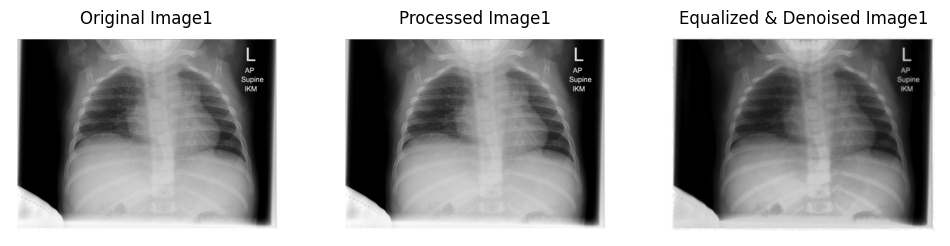

In [103]:
# Visualize the original, preprocessed, and denoised images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
img_original1 = cv2.imread(img_path1)
plt.imshow(cv2.cvtColor(img_original1, cv2.COLOR_BGR2RGB))
plt.title('Original Image1')
plt.axis('off')

# Processed Image (Grayscale & Normalized)
plt.subplot(1, 3, 2)
plt.imshow(img_processed1.squeeze(), cmap='gray')
plt.title('Processed Image1')
plt.axis('off')

# Equalized and Denoised Image (Optional)
plt.subplot(1, 3, 3)
plt.imshow(img_denoised1, cmap='gray')
plt.title('Equalized & Denoised Image1')
plt.axis('off')

plt.show()

In [104]:
import tensorflow as tf



In [105]:
img=np.expand_dims(img,axis=0)
img1=np.expand_dims(img1,axis=0)


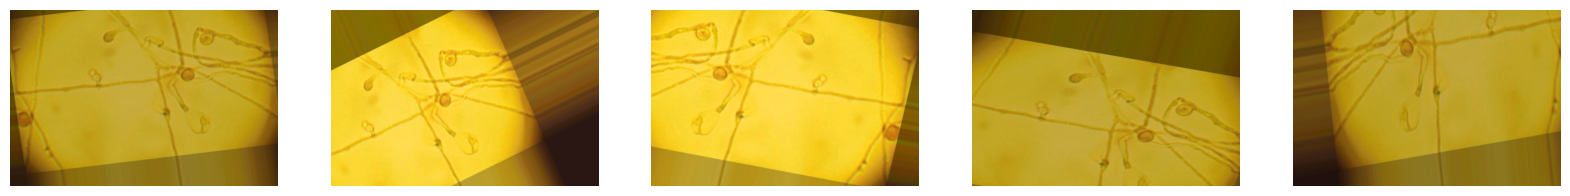

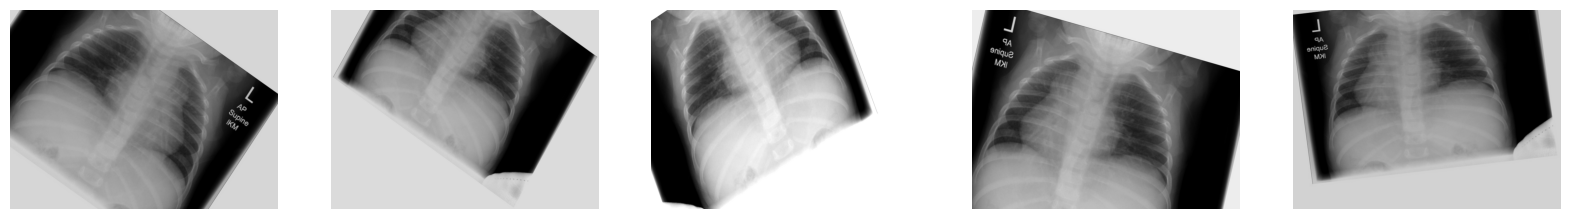

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define more diverse augmentation settings
datagen = ImageDataGenerator(
    rotation_range=40,            # Randomly rotate images within 40 degrees
    width_shift_range=0.2,        # Shift images horizontally by 20% of the width
    height_shift_range=0.2,       # Shift images vertically by 20% of the height
    shear_range=0.2,              # Shear transformation with a shear intensity of 20%
    zoom_range=0.2,               # Randomly zoom in on images by 20%
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill pixels that are outside the boundaries
)

# Apply augmentation to a single image
augmented_images = [next(datagen.flow(img, batch_size=1))[0] for _ in range(5)]

# Display augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_img.astype('uint8'))
    plt.axis('off')
plt.show()


augmented_images1 = [next(datagen.flow(img1, batch_size=1))[0] for _ in range(5)]

# Display augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
for i, aug_img1 in enumerate(augmented_images1):
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_img1.astype('uint8'))
    plt.axis('off')
plt.show()


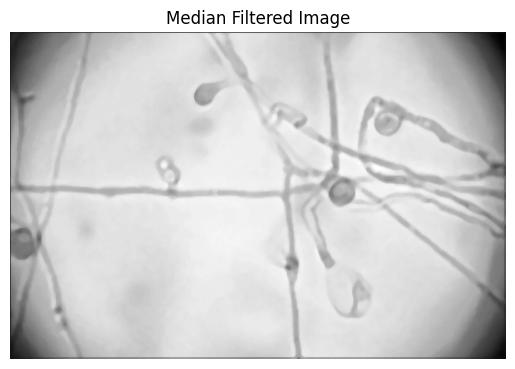

In [107]:
# Apply median filtering
img_median = cv2.medianBlur(img_processed, 5)  # Adjust kernel size (5x5)

# Display result
plt.imshow(img_median, cmap='gray')
plt.title("Median Filtered Image")
plt.axis('off')
plt.show()


In [108]:
#Convert images to tensors using libraries like TensorFlow or PyTorch, as most deep learning models work with tensor data.

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_array = img_to_array(img_processed)

# Convert numpy array to tensor
image_tensor = tf.convert_to_tensor(image_array)

# Optionally, add a batch dimension if you need it (e.g., for model inference)
image_tensor = tf.expand_dims(image_tensor, axis=0)
# Normalize pixel values to [0, 1] if required
image_tensor = image_tensor / 255.0
print(image_tensor)

tf.Tensor(
[[[[0.1254902 ]
   [0.12941177]
   [0.12941177]
   ...
   [0.10196079]
   [0.10980392]
   [0.10196079]]

  [[0.1254902 ]
   [0.13333334]
   [0.14509805]
   ...
   [0.07450981]
   [0.09019608]
   [0.08627451]]

  [[0.13333334]
   [0.14901961]
   [0.16078432]
   ...
   [0.0627451 ]
   [0.08235294]
   [0.08627451]]

  ...

  [[0.11764706]
   [0.12941177]
   [0.13725491]
   ...
   [0.08627451]
   [0.09019608]
   [0.09411765]]

  [[0.11764706]
   [0.1254902 ]
   [0.13333334]
   ...
   [0.09411765]
   [0.09411765]
   [0.09411765]]

  [[0.11372549]
   [0.1254902 ]
   [0.12941177]
   ...
   [0.09411765]
   [0.09411765]
   [0.08627451]]]], shape=(1, 355, 539, 1), dtype=float32)


In [109]:
# For Image1

image_array1 = img_to_array(img_processed1)

# Convert numpy array to tensor
image_tensor1 = tf.convert_to_tensor(image_array1)

# Optionally, add a batch dimension if you need it (e.g., for model inference)
image_tensor1 = tf.expand_dims(image_tensor1, axis=0)
# Normalize pixel values to [0, 1] if required
image_tensor1 = image_tensor1 / 255.0
print(image_tensor1)

tf.Tensor(
[[[[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  ...

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]], shape=(1, 559, 750, 1), dtype=float32)


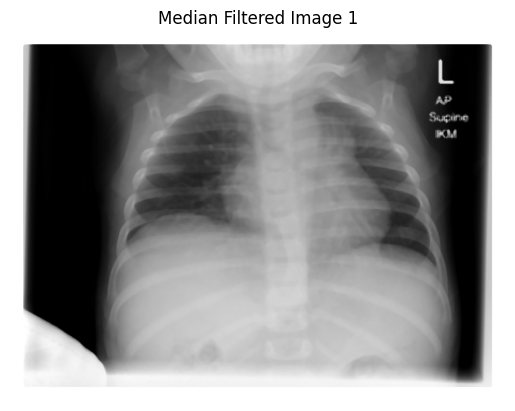

In [110]:
# Apply median filtering
img_median1 = cv2.medianBlur(img_processed1, 5)  # Adjust kernel size (5x5)

# Display result
plt.imshow(img_median1, cmap='gray')
plt.title("Median Filtered Image 1")
plt.axis('off')
plt.show()

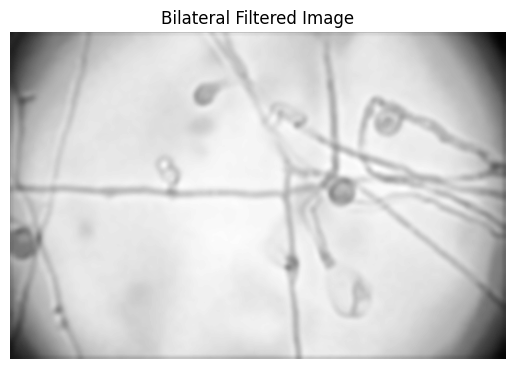

In [111]:
# Apply bilateral filtering
img_bilateral = cv2.bilateralFilter(img_processed, d=9, sigmaColor=75, sigmaSpace=75)

# Display result
plt.imshow(img_bilateral, cmap='gray')
plt.title("Bilateral Filtered Image")
plt.axis('off')
plt.show()


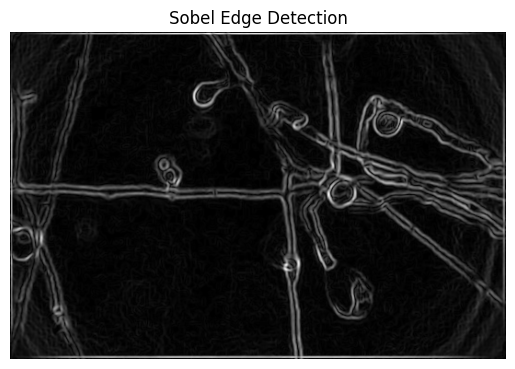

In [112]:
# Apply Sobel edge detection on the grayscale image
sobel_x = cv2.Sobel(img_processed, cv2.CV_64F, 1, 0, ksize=5)  # Horizontal edges
sobel_y = cv2.Sobel(img_processed, cv2.CV_64F, 0, 1, ksize=5)  # Vertical edges

# Combine edges
sobel_combined = cv2.magnitude(sobel_x, sobel_y)

# Display result
plt.imshow(sobel_combined, cmap='gray')
plt.title("Sobel Edge Detection")
plt.axis('off')
plt.show()


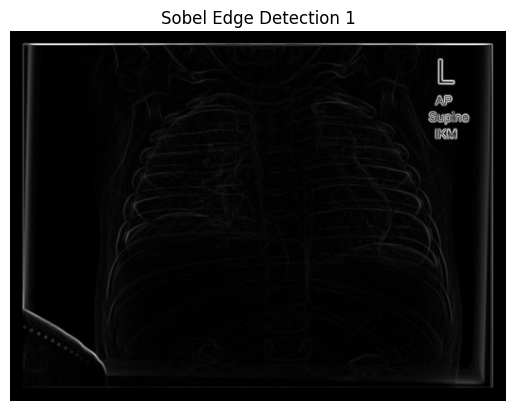

In [113]:
# Apply Sobel edge detection on the grayscale image
sobel_x1 = cv2.Sobel(img_processed1, cv2.CV_64F, 1, 0, ksize=5)  # Horizontal edges
sobel_y1 = cv2.Sobel(img_processed1, cv2.CV_64F, 0, 1, ksize=5)  # Vertical edges

# Combine edges
sobel_combined1 = cv2.magnitude(sobel_x1, sobel_y1)

# Display result
plt.imshow(sobel_combined1, cmap='gray')
plt.title("Sobel Edge Detection 1")
plt.axis('off')
plt.show()

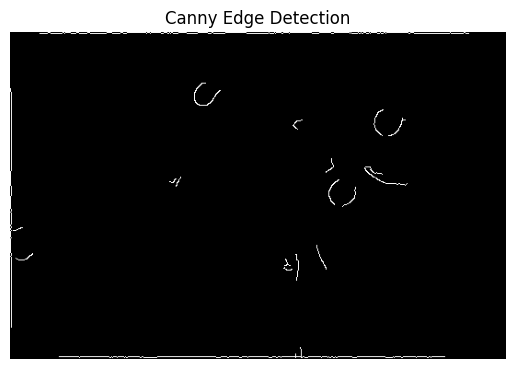

In [114]:
# Apply Canny edge detection
edges = cv2.Canny(img_processed, threshold1=100, threshold2=200)

# Display result
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()


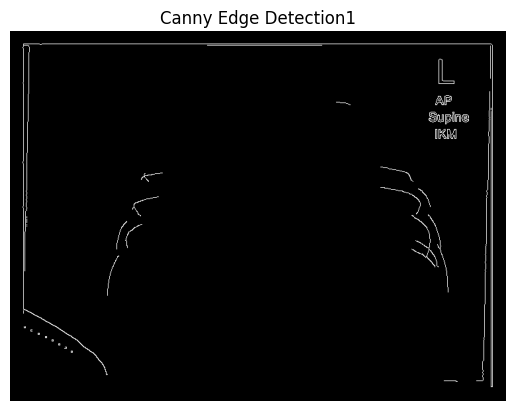

In [115]:
# Apply Canny edge detection
edges1 = cv2.Canny(img_processed1, threshold1=100, threshold2=200)

# Display result
plt.imshow(edges1, cmap='gray')
plt.title("Canny Edge Detection1")
plt.axis('off')
plt.show()

In [116]:
!git clone https://github.com/SpringBoard795/PicasoPhrase_Infosys_Internship_Nov2024.git

Cloning into 'PicasoPhrase_Infosys_Internship_Nov2024'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 23 (delta 2), reused 14 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 4.86 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [117]:


%cd PicasoPhrase_Infosys_Internship_Nov2024/

/content/PicasoPhrase_Infosys_Internship_Nov2024


In [118]:

!git config --global user.email "jakkampudisatyasai@gmail.com"
!git config --global user.name "J P V Satya Sai"

In [119]:

!git checkout -b JPVSatyaSai_branch

Switched to a new branch 'JPVSatyaSai_branch'


In [120]:
!git add .

In [121]:

!git status

On branch JPVSatyaSai_branch
nothing to commit, working tree clean


In [122]:
!git commit -m "Caption and Image Preprocessing Techniques"

On branch JPVSatyaSai_branch
nothing to commit, working tree clean


In [123]:
!git push origin JPVSatyaSai_branch

fatal: could not read Username for 'https://github.com': No such device or address
